In [1]:

import glob
import os
import shutil
import json
import cv2
import h5py
import traceback


import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import scipy.stats as spstats
import tifffile as tf

import matplotlib.colors as mcolors
import cPickle as pkl

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pipeline.python.utils import convert_range

from pipeline.python.utils import natural_keys, label_figure
from pipeline.python import utils as putils

from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.coregistration import align_fov as coreg

from scipy import ndimage

from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap




/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/do_retinotopy_analysis.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    a

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/rois/utils.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/hom

In [2]:
%matplotlib notebook

# Select dataset

In [3]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

animalid = 'JC091' #'JC085'
session = '20190607' #'20190626'
fov = 'FOV1_zoom2p0x'
retinorun = 'retino_run1'
data_identifier = '|'.join([animalid, session, fov, retinorun])


# Set output dirs

In [4]:
outdir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(outdir):
    os.makedirs(outdir)
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Load data

In [5]:
traceid = 'traces001'

# Load data metainfo
run_dir = os.path.join(rootdir, animalid, session, fov, retinorun)
RETID = ret_utils.load_retinoanalysis(run_dir, traceid)
analysis_dir = RETID['DST']
retinoid = RETID['analysis_id']
print("Loaded: %s, %s (%s))" % (retinorun, retinoid, run_dir))
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("data ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) # load_si(run_dir)
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
curr_dst_dir = os.path.join(analysis_dir, 'retino-structure')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print("Saving output to:\n %s" % curr_dst_dir)


Loaded: retino_run1, analysis002 (/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1))
data ID: JC091_20190607_FOV1_zoom2p0x_retino_run1_analysis002
Saving output to:
 /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_a79b6d/retino-structure


In [6]:
print("Saving current output to:\n %s" % curr_dst_dir)

Saving current output to:
 /n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_a79b6d/retino-structure


# Select colormap

In [7]:
reload(ret_utils)
reload(putils)

<module 'pipeline.python.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/utils.pyc'>

<IPython.core.display.Javascript object>


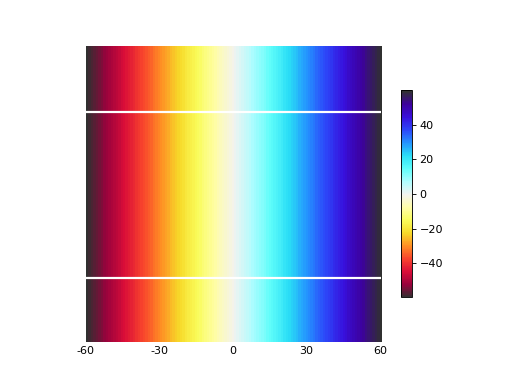

(u'/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_a79b6d/retino-structure', 'azimuth_pos_nic_Edge_LEGEND_abs')


<IPython.core.display.Javascript object>


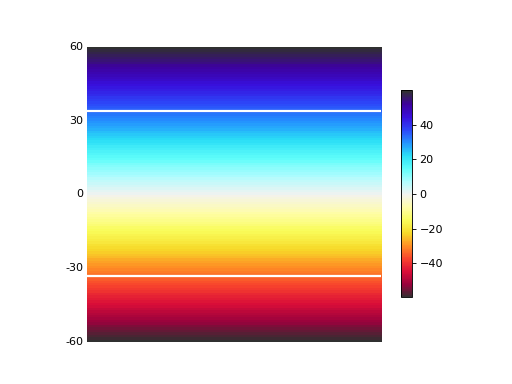

(u'/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_a79b6d/retino-structure', 'elevation_pos_nic_Edge_LEGEND_abs')


In [8]:
# Load colormap
cmap_name = 'nic_Edge'
zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=zero_center, return_cmap=True, dst_dir=curr_dst_dir)

    

# Process raw traces

In [65]:
reload(ret_utils)

<module 'pipeline.python.retinotopy.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/utils.pyc'>

In [9]:
#### Load raw and process traces -- returns average trace for condition
retino_dpath = os.path.join(analysis_dir, 'traces', 'extracted_traces.h5')
temporal_ds = float(RETID['PARAMS']['average_frames'])
np_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='neuropil')
soma_traces = ret_utils.load_traces(animalid, session, fov, run=retinorun,
                                  analysisid=retinoid, trace_type='raw')

... loading traces (neuropil)
... loading traces (raw)


In [10]:
soma_traces['top'].shape

(2233, 526)

# Do fft

73 out of 526 cells pass mag-ratio thr (thr>=0.01)


<IPython.core.display.Javascript object>


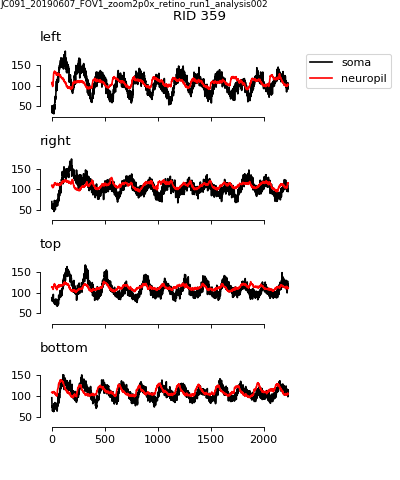

In [11]:
pass_criterion = 'all' # 'any'
mag_thr=0.01
plot_examples =True


#### Get FFT params
n_frames = scaninfo['stimulus']['n_frames']
frame_rate = scaninfo['stimulus']['frame_rate']
stim_freq_idx = scaninfo['stimulus']['stim_freq_idx']
freqs = np.fft.fftfreq(n_frames, float(1./frame_rate)) # Label frequency bins
sorted_freq_idxs = np.argsort(freqs)

#### Do FFT
fft_soma = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in soma_traces.items())
fft_np = dict((cond, ret_utils.do_fft_analysis(tdf, sorted_freq_idxs, stim_freq_idx)) for cond, tdf in np_traces.items())

# Get magratios -- each column is a condition
magratios_soma = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_soma.items()))
magratios_np = pd.DataFrame(dict((cond, k[0]) for cond, k in fft_np.items()))

# Get phases
phases_soma = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_soma.items()))
phases_np = pd.DataFrame(dict((cond, k[1]) for cond, k in fft_np.items()))

# Get average across conditions
mean_magratio_values_soma = magratios_soma.mean(axis=1).values 
mean_magratio_values_np = magratios_np.mean(axis=1).values

# Sort ROIs by their average mag ratios
sorted_rois_soma = np.argsort(mean_magratio_values_soma)[::-1]

# Filter out bad cells
if pass_criterion=='all':
    roi_list = [i for i in magratios_soma.index if all(magratios_soma.loc[i] > mag_thr)]
elif pass_criterion=='any':
    roi_list = [i for i in magratios_soma.index if any(magratios_soma.loc[i] > mag_thr)]
else:
    roi_list = magratios_soma.index.tolist()
print("%i out of %i cells pass mag-ratio thr (thr>=%.2f)" % (len(roi_list), len(mean_magratio_values_soma), mag_thr))
sorted_by_mag = [r for r in sorted_rois_soma if r in roi_list]

# Look at example cell
if plot_examples:
    ret_utils.plot_some_example_traces(soma_traces, np_traces, plot_rois=sorted_rois_soma[0:3],
                         dst_dir=curr_dst_dir, data_id=data_id)
    

In [12]:
magratios_np.shape

(526, 4)

###### magratios_soma.shape

# Get mask info

In [13]:
# Get ROIID and projection image
masks_soma, masks_np, zimg = ret_utils.load_soma_and_np_masks(RETID)
roiid = RETID['PARAMS']['roi_id']
ds_factor = int(RETID['PARAMS']['downsample_factor'])
nrois_total, d1, d2 = masks_soma.shape

... FOV size: (256, 256) (downsample factor=2)


<IPython.core.display.Javascript object>


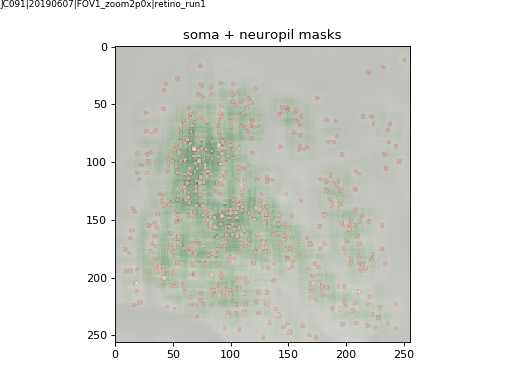

In [14]:
fig, ax = pl.subplots()
roi_utils.plot_neuropil_masks(masks_soma, masks_np, zimg, ax=ax)
ax.set_title('soma + neuropil masks')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(curr_dst_dir, 'soma-v-neuropil-masks.png'))

# Dilate soma masks
From Liang et al., 2018, Cell.
1. Assign center of neuropil ring w/ preferred retino location.
2. From Neurpil ring center, dilate by a disk of 10um radius (20um diam)
3. Average overlapping disks
4. Spatially smooth w/ isotropic 2D Guassian filter (std=2um) for final pixe-wise estimates 

In [15]:
import imutils
from scipy.ndimage.morphology import binary_dilation


In [16]:
def dilate_mask_centers(maskcenters, kernel_size=9):
    '''Calculate center of soma, then dilate to create masks for smoothed  neuropil
    '''
    kernel_radius = (kernel_size - 1) // 2
    x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
    dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

    # let's create three kernels for the sake of example
    radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
    # using ... allows compatibility with arbitrarily-shaped radius arrays

    kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)

    dilated_masks = np.zeros(maskcenters.shape, dtype=maskcenters.dtype)
    for roi in range(maskcenters.shape[0]):
        img = maskcenters[roi, :, :].copy()
        x, y = np.where(img>0)
        centroid = (sum(x) / len(x), sum(y) / len(x))
        #print(centroid)
        np_tmp = np.zeros(img.shape, dtype=bool)
        np_tmp[centroid] = True
        dilation = binary_dilation(np_tmp, structure=kernel )
        dilated_masks[roi, : :] = dilation
    return dilated_masks

def mask_rois(masks, value_array, mask_thr=0.1, return_array=False):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    nrois, d1, d2 = masks.shape
    dims = (d1, d2)

    if return_array:
        value_mask = np.ones(masks.shape)*np.nan #-100
        for rid in value_array.index.tolist():
            value_mask[rid, masks[rid,:,:]>=mask_thr] = value_array[rid]

    else:
        value_mask =  np.ones(dims)*-100
        for rid in value_array.index.tolist():
            value_mask[masks[rid,:,:]>=mask_thr] = value_array[rid]

    return value_mask



def mask_with_overlaps_averaged(dilated_masks, value_array, mask_thr=0.1,
                               is_circular=False, vmin=-np.pi, vmax=np.pi):
    '''
    value_array: indices should be RIDs -- these ixs are used to index into masks.
    '''
    
    nrois, d1, d2 = dilated_masks.shape
    
    # Get non-averaged array, shape=(d1, d2)
    tmpmask = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=False)
    #print("no array:", tmpmask.shape, value_array.shape)
    
    # Get full array to average across overlapping pixels, shape=(nrois, d1, d2)?
    tmpmask_full = mask_rois(dilated_masks, value_array, mask_thr=mask_thr, return_array=True)
    #print("arr:", tmpmask_full.shape, value_array.shape)
    tmpmask_r = np.reshape(tmpmask_full, (nrois_total, d1*d2))
    
    # Replace overlapping pixels with average value
    avg_mask = tmpmask.copy().ravel()
    multi_ixs = [i for i in range(tmpmask_r.shape[-1]) if len(np.where(tmpmask_r[:, i])[0]) > 1]
    for ix in multi_ixs:
        if is_circular:
            avg_mask[ix] = spstats.circmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)], low=vmin, high=vmax)
        else:
            avg_mask[ix] = np.nanmean([v for v in tmpmask_r[:, ix] if not np.isnan(v)])#, low=vmin, high=vmax)

    avg_mask = np.reshape(avg_mask, (d1, d2))

    return avg_mask

In [17]:
# measured pixel size: (2.3, 1.9)
# want to dilate by ~9.52380952381

desired_radius_um = 10.0 #20.0

pixel_size = putils.get_pixel_size()
#pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)
print(pixel_size)
um_per_pixel = np.mean(pixel_size) / ds_factor # divide by DS factor (pixels are half if ds=2)

pixels2dilate = desired_radius_um/um_per_pixel
print(pixels2dilate)

(2.3, 1.9)
9.52380952381


(11, 11)


<IPython.core.display.Javascript object>


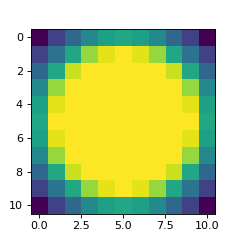

Dilation diameter (um): 11.55


<IPython.core.display.Javascript object>


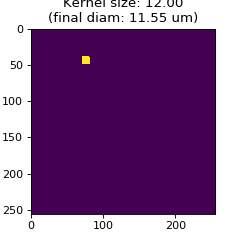

10
10


In [18]:
check_masks = True

# Set kernel params
kernel_size = np.ceil(pixels2dilate+2) #21
kernel_radius = (kernel_size - 1) // 2
x, y = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
dist = (x**2 + y**2)**0.5 # shape (kernel_size, kernel_size)

# Create three kernels for the sake of example
radii = np.array([kernel_size/3., kernel_size/2.5, kernel_size/2.])[...,None,None] # shape (num_radii, 1, 1)
# using ... allows compatibility with arbitrarily-shaped radius arrays
kernel = (1 - (dist - radii).clip(0,1)).sum(axis=0)# shape (num_radii, kernel_size, kernel_size)
print(kernel.shape)


if check_masks:
    pl.figure(figsize=(3,3))
    pl.imshow(kernel)
    kernel_diam_um = (kernel.shape[0]*um_per_pixel)
    print("Dilation diameter (um): %.2f" % kernel_diam_um)

## Dilate all masks with kernel
dilated_masks = dilate_mask_centers(masks_soma.astype(float), kernel_size=kernel_size)

if check_masks:
    rid = 33
    pl.figure(figsize=(3,3))
    pl.imshow(dilated_masks[rid, :, :])
    pl.title("Kernel size: %.2f\n(final diam: %.2f um)" % (kernel_size, kernel_diam_um))
    x, y = np.where(dilated_masks[rid, :, :]>0)
    print x.max()-x.min()
    print y.max()-y.min()


# Assign phase to neuropil

In [19]:
def get_phase_masks(masks, phases, average_overlap=True, roi_list=None, use_cont=True, mask_thr=0.01,
                   is_circular=True):
    # Convert phase to continuous:
    phases_cont = -1 * phases
    phases_cont = phases_cont % (2*np.pi)
    
    # Only include specified rois:
    if roi_list is None:
        roi_list = phases.index.tolist()
        
    # Get absolute maps:
    if use_cont:
        elev = (phases_cont['bottom'] - phases_cont['top']) / 2.
        azim = (phases_cont['left'] - phases_cont['right']) / 2.
        vmin = -np.pi
        vmax = np.pi
    else:
        # Get absolute maps:
        elev = (phases['bottom'] - phases['top']) / 2.
        azim = (phases['left'] - phases['right']) / 2.
        
        # Convert to continueous:
        elev_c = -1 * elev
        elev_c = elev_c % (2*np.pi)
        azim_c = -1 * azim
        azim_c = azim_c % (2*np.pi)

        vmin = 0
        vmax = 2*np.pi

        azim = copy.copy(azim_c)
        elev = copy.copy(elev_c)
    
    # azim, elv :  Series, indices are roi IDs (use roi_list to index into the correct values)
    if average_overlap:
        azim_phase = mask_with_overlaps_averaged(masks, azim[roi_list], mask_thr=mask_thr,
                                                is_circular=is_circular, vmin=vmin, vmax=vmax)
        elev_phase = mask_with_overlaps_averaged(masks, elev[roi_list], mask_thr=mask_thr,
                                                is_circular=is_circular, vmin=vmin, vmax=vmax)
    else:
        azim_phase = mask_rois(masks, azim[roi_list], mask_thr=mask_thr)
        elev_phase = mask_rois(masks, elev[roi_list], mask_thr=mask_thr)   
    
    return azim_phase, elev_phase



In [112]:
use_cont = True
average_overlap = True
filter_by_mag = True
mask_thr=0.01

# Set bounds for averaging
vmin = -np.pi if use_cont else 0
vmax = np.pi if use_cont else 2*np.pi

# Assign phase value to dilated masks
azim_phase_np, elev_phase_np = get_phase_masks(dilated_masks, phases_np, average_overlap=average_overlap, 
                                               roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

azim_phase_soma, elev_phase_soma = get_phase_masks(masks_soma, phases_soma, average_overlap=average_overlap, 
                                                   roi_list=roi_list, use_cont=use_cont, mask_thr=mask_thr)

# Mask images for plotting
azim_phase_mask_np = np.ma.masked_where(azim_phase_np==-100, azim_phase_np)
elev_phase_mask_np = np.ma.masked_where(elev_phase_np==-100, elev_phase_np)

azim_phase_mask_soma = np.ma.masked_where(azim_phase_soma==-100, azim_phase_soma)
elev_phase_mask_soma = np.ma.masked_where(elev_phase_soma==-100, elev_phase_soma)


# Check resizing

In [113]:
pixel_size = putils.get_pixel_size()

pixel_size = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)

((256, 256), (1177, 972))


<IPython.core.display.Javascript object>


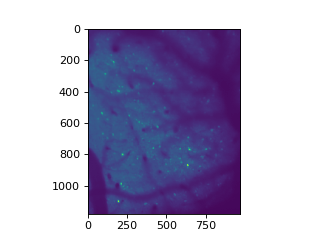

In [114]:
zimg_r = coreg.transform_2p_fov(zimg, pixel_size)
print(zimg.shape, zimg_r.shape)

pl.figure(figsize=(4,3))
pl.imshow(zimg_r)

# Smooth

In [115]:
from scipy.interpolate import SmoothBivariateSpline

def fill_and_smooth_nas(img):

    y, x = np.meshgrid(np.arange(0, img.shape[1]), np.arange(0, img.shape[0]))
    x = x.astype(float)
    y = y.astype(float)
    z = img.copy()
    
    xx = x.copy()
    yy = y.copy()
    xx[np.isnan(z)] = np.nan
    yy[np.isnan(z)] = np.nan

    xx=xx.ravel()
    xx=(xx[~np.isnan(xx)])
    yy=yy.ravel()
    yy=(yy[~np.isnan(yy)])
    zz=z.ravel()
    zz=(zz[~np.isnan(zz)])

#     xnew = np.arange(xx.min(), xx.max()+1) #np.arange(9,11.5, 0.01)
#     ynew = np.arange(yy.min(), yy.max()+1) #np.arange(10.5,15, 0.01)

#     f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
#     znew=np.transpose(f(xnew, ynew)).T

    xnew = np.arange(x.ravel().min(), x.ravel().max()+1) #np.arange(9,11.5, 0.01)
    ynew = np.arange(y.ravel().min(), y.ravel().max()+1) #np.arange(10.5,15, 0.01)
    
    #print(xnew.min(), xnew.max())
    
    f = SmoothBivariateSpline(xx,yy,zz,kx=1,ky=1)
    znew=f(xnew, ynew) #).T
    
    znew[np.isnan(z)] = np.nan
    
    #print(z.shape, znew.shape)
    return znew #.T #a


In [35]:
# # Spatial smooth neuropil dilated masks 
# smooth_fwhm = 7 #21

# azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)

# a_test = fill_and_smooth_nas(azim_smoothed)


In [116]:
# Spatial smooth neuropil dilated masks 
smooth_fwhm = 7 #21
azim_smoothed = ret_utils.smooth_neuropil(azim_phase_np, smooth_fwhm=smooth_fwhm)
elev_smoothed = ret_utils.smooth_neuropil(elev_phase_np, smooth_fwhm=smooth_fwhm)
print(azim_phase_np.shape, azim_smoothed.shape)

if 'zoom1p0x' in fov:
    print("... resizing")
    azim_smoothed = cv2.resize(azim_smoothed, (new_d1, new_d2))
    elev_smoothed = cv2.resize(elev_smoothed, (new_d1, new_d2))
    
azim_smoothed = fill_and_smooth_nas(azim_smoothed)
elev_smoothed = fill_and_smooth_nas(elev_smoothed)
print(azim_phase_np.shape, azim_smoothed.shape)

# Transform FOV to match widefield
azim_r = coreg.transform_2p_fov(azim_smoothed, pixel_size, normalize=False)
elev_r = coreg.transform_2p_fov(elev_smoothed, pixel_size, normalize=False)
# print(azim_r[~np.isnan(azim_r)].min(), azim_r[~np.isnan(azim_r)].max())

az_fill = azim_r.copy()
el_fill = elev_r.copy()
# # Fill and smooth over NaNs
# az_fill = fill_and_smooth_nas(azim_r)
# el_fill = fill_and_smooth_nas(elev_r)

#print(azim_phase_np.shape, azim_smoothed.shape, az_fill.shape)

((256, 256), (256, 256))
((256, 256), (256, 256))


In [117]:
azim_phase_mask_np.shape, azim_smoothed.shape

((256, 256), (256, 256))

In [118]:
azim_smoothed.max()

nan

<IPython.core.display.Javascript object>


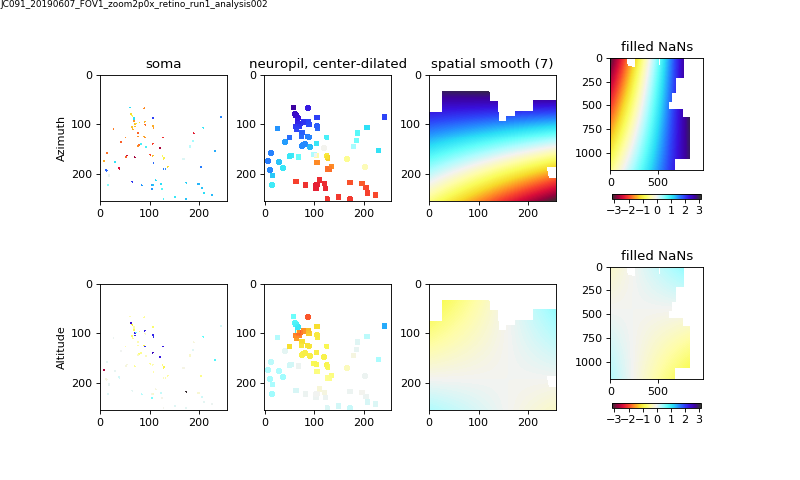

(u'/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_a79b6d/retino-structure', 'soma-v-neuropil_dilate-center-12_spatial-smooth-7_circ_magthr-0.01')


In [119]:
fig, axn = pl.subplots(2,4, figsize=(10,6))

ax = axn[0,0]
ax.imshow(azim_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('soma')
ax.set_ylabel('Azimuth')

ax = axn[0, 1]
ax.imshow(azim_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('neuropil, center-dilated')

ax = axn[0, 2]
ax.imshow(azim_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('spatial smooth (%i)' % smooth_fwhm)

ax = axn[0, 3]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)


ax = axn[1, 0]
ax.imshow(elev_phase_mask_soma, cmap=cmap_phase, vmin=vmin, vmax=vmax)
#ax.set_title('soma')
ax.set_ylabel('Altitude')

ax = axn[1, 1]
ax.imshow(elev_phase_mask_np, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 2]
ax.imshow(elev_smoothed, cmap=cmap_phase, vmin=vmin, vmax=vmax)

ax = axn[1, 3]
im1= ax.imshow(el_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
ax.set_title('filled NaNs')
pl.colorbar(im1, ax=ax, orientation='horizontal', shrink=0.7)

pl.subplots_adjust(wspace=0.3, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'soma-v-neuropil_dilate-center-%i_spatial-smooth-%i_circ_magthr-%.2f' % (kernel_size, smooth_fwhm, mag_thr)

#pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)

In [105]:
el_fill.max()

0.43688992296241774

In [45]:
azim_phase_mask_soma.shape

(256, 256)

In [46]:
azim_soma_r = coreg.transform_2p_fov(azim_phase_mask_soma, pixel_size, normalize=False)


<IPython.core.display.Javascript object>


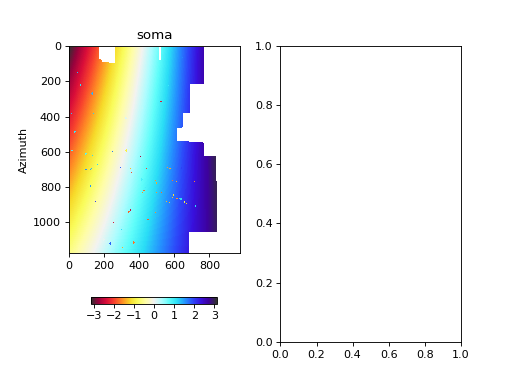

Text(0,0.5,u'Azimuth')

In [49]:
fig, axn = pl.subplots(1, 2)

ax = axn[0]
im0 = ax.imshow(az_fill, cmap=cmap_phase, vmin=vmin, vmax=vmax)
pl.colorbar(im0, ax=ax, orientation='horizontal', shrink=0.7)
ax.imshow(azim_soma_r, cmap=cmap_phase, vmin=vmin, vmax=vmax)


ax.set_title('soma')
ax.set_ylabel('Azimuth')


#### Plot smoothed azimuth neuropil

In [27]:
# cmap = 'nipy_spectral' # cmap_phase
# overlay = True
# overlay_str = '_overlay' if overlay else ''
# alpha = 0.5 if overlay else 1.0

# fig, axn = pl.subplots(1,2)
# ax = axn[0]
# if overlay:
#     ax.imshow(zimg_r, cmap='gray')
# ax.imshow(azim_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
# ax.set_title('Azimuth')

# ax = axn[1]
# if overlay:
#     ax.imshow(zimg_r, cmap='gray')
# ax.imshow(elev_r, cmap=cmap_phase, vmin=vmin, vmax=vmax, alpha=alpha)
# ax.set_title('Altitude')

# figname = 'smoothed_neuropil_dilate-%i_spatial-fwhm-%i%s' % (kernel_size, smooth_fwhm, overlay_str)

# pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))


# Calculate image gradient

In [90]:
def calculate_gradients(img):
    # Get gradient
    gdy, gdx = np.gradient(img)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(gdx**2 + gdy**2)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scale_factor = np.max(gradmag)/255
    #gradmag = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the x and y gradients
    abs_gdx = np.absolute(gdx)
    abs_gdy = np.absolute(gdy)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    abs_gd = np.arctan2(gdy, gdx) # np.arctan2(abs_gdy, abs_gdx) # [-pi, pi]

    # Get mean direction
    #mean_dir = np.rad2deg(np.arctan2(gdy.mean(), gdx.mean())) # TODO why this diff
#     mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())],
#                          low=-np.pi, high=np.pi)) # TODO why this diff
    mean_dir = np.rad2deg(spstats.circmean([np.arctan2(gy, gx) for gy, gx in zip(gdy.ravel(), gdx.ravel())\
                                               if ((not np.isnan(gy)) and (not np.isnan(gx)))],
                         low=-np.pi, high=np.pi)) # TODO why this diff

    # Get unit vector
    avg_gradient = spstats.circmean(abs_gd[~np.isnan(abs_gd)], low=-np.pi, high=np.pi) #.mean()
    dirvec = (np.cos(avg_gradient), np.sin(avg_gradient))
    vhat = dirvec / np.linalg.norm(dirvec)

    grad_ = {'image': img,
             'magnitude': gradmag,
             'gradient_x': gdx,
             'gradient_y': gdy,
             'direction': abs_gd,
             'mean_deg': mean_dir, # DEG
             'mean_direction': avg_gradient, # RADIANS
             'vhat': vhat}
    
    return grad_


def plot_gradients(grad_, ax=None, draw_interval=3, scale=1, width=0.005, toy=False, headwidth=5):
    '''
    scale:  # of dat units per arrow length unit (smaller=longer arrow)
    scale_units 
    weight = width of plot
    angles='xy' (i.e., arrows point from (x,y) to (x+u, y+v))
    Arrows should point TOWARD larger numbers
    '''
    if ax is None:
        fig, ax = pl.subplots()
        
    gradimg = grad_['image']
    mean_dir = grad_['mean_deg']
    gdx = grad_['gradient_x']
    gdy = grad_['gradient_y']
    
    # Set limits and number of points in grid
    y, x = np.mgrid[0:gradimg.shape[0], 0:gradimg.shape[1]]

    # Every 3rd point in each direction.
    skip = (slice(None, None, draw_interval), slice(None, None, draw_interval))
    
    # plot
    ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], color='k',
              scale=scale, width=width,
              scale_units='xy', angles='xy', pivot='mid', units='width',
              headwidth=headwidth)
    
    gdir_ = grad_['direction'].copy()
    gmean = spstats.circmean(gdir_[~np.isnan(gdir_)], low=-np.pi, high=np.pi)
    
    avg_dir_grad = np.rad2deg(gmean) #np.nanmean(grad_['direction']))
    
    ax.set(aspect=1, title="Mean: %.2f\n(dir: %.2f)" % (mean_dir, avg_dir_grad))

    return ax

In [89]:
d_ = grad_el['direction'].copy()
#d_[~np.isnan(d_)].min(), d_[~np.isnan(d_)].max()

print np.nanmean(grad_el['direction'])
print d_[~np.isnan(d_)].mean()

-0.692294194162
-0.692294194162


#### Test w/ toy example

In [68]:
# Create some images going in various directions
gradimg = np.ones((60, 30))
for i in range(30):
    gradimg[:, i] = gradimg[:, i]*(i**2)*0.01
gradimg = gradimg.astype(float)
gradimg_lr = np.fliplr(gradimg.copy()) #gradimg.T
gradimg_ud = gradimg.copy().T
gradimg_du = np.flipud(gradimg_ud)

# Calculate gradients
grad_ = calculate_gradients(gradimg)
grad_lr = calculate_gradients(gradimg_lr)
grad_ud = calculate_gradients(gradimg_ud)
grad_du = calculate_gradients(gradimg_du)


<IPython.core.display.Javascript object>


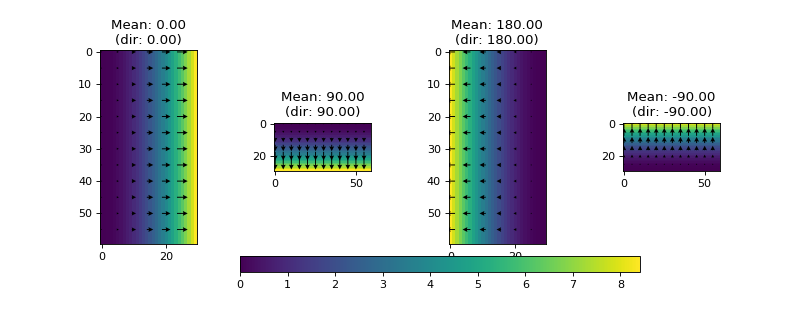

In [91]:
# Yellow = higher #s, arrows should point in direction toward higher
spacing = 5
scale=None
width=0.01
headwidth=5

fig, axn = pl.subplots(1,4, figsize=(10, 4))
cbar_ax = fig.add_axes([0.3, 0.15, 0.5, 0.05])

ax = axn[0]
ax.imshow(grad_['image'])
plot_gradients(grad_, ax=ax,draw_interval=spacing, toy=True, 
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[1]
ax.imshow(grad_ud['image'])
plot_gradients(grad_ud, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[2]
ax.imshow(grad_lr['image'])
plot_gradients(grad_lr, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

ax = axn[3]
im = ax.imshow(grad_du['image'])
plot_gradients(grad_du, ax=ax, draw_interval=spacing, toy=True,
               headwidth=headwidth, scale=scale, width=width)
#ax.invert_yaxis()

pl.subplots_adjust(wspace=0.8)
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
pl.subplots_adjust(bottom=0.2)
pl.savefig(os.path.join(curr_dst_dir, 'test_gradient_dirs.png'))

## Test calculation of slope with toy ex

In [53]:
gimg = grad_['image'].copy()
d1, d2 = grad_['image'].shape
print(d1, d2)
vhat_ = grad_['vhat']

# gimg = grad_az['image'].copy()
# d1, d2 = grad_az['image'].shape
# print(d1, d2)
# vhat_ = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))

(60, 30)


<IPython.core.display.Javascript object>


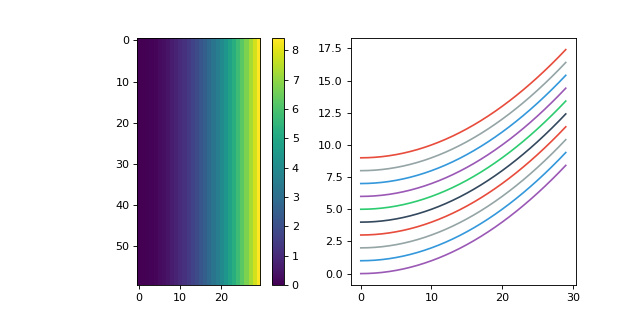

In [54]:
fig, axn =pl.subplots(1,2, figsize=(8,4))
i0 = axn[0].imshow(gimg)
pl.colorbar(i0, ax=axn[0])

ax=axn[1]

n=10
for i in np.arange(0, n):
    axn[1].plot(gimg[i,:] + i)

#### Project and test

In [29]:
proj_az = np.array([np.dot(np.array((xv, yv)), vhat_) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])
pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])

ret_az = np.array([gimg[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])

NameError: name 'vhat_' is not defined

In [69]:
n=60
for c, i, v in zip(coords[0:n], proj_az[0:n], ret_az[0:n]):
    print('[%i, %i] %.2f, %.2f' % (c[0], c[1], i,v))
    
print('--------last few:')
print(coords[-5:])

[0, 0] 0.00, 0.00
[1, 0] 1.00, 0.00
[2, 0] 1.99, 0.00
[3, 0] 2.99, 0.00
[4, 0] 3.99, 0.00
[5, 0] 4.98, 0.00
[6, 0] 5.98, 0.00
[7, 0] 6.98, 0.00
[8, 0] 7.97, 0.00
[9, 0] 8.97, 0.00
[10, 0] 9.97, 0.00
[11, 0] 10.96, 0.00
[12, 0] 11.96, 0.00
[13, 0] 12.95, 0.00
[14, 0] 13.95, 0.00
[15, 0] 14.95, 0.00
[16, 0] 15.94, 0.00
[17, 0] 16.94, 0.00
[18, 0] 17.94, 0.00
[19, 0] 18.93, 0.00
[20, 0] 19.93, 0.00
[21, 0] 20.93, 0.00
[22, 0] 21.92, 0.00
[23, 0] 22.92, 0.00
[24, 0] 23.92, 0.00
[25, 0] 24.91, 0.00
[26, 0] 25.91, 0.00
[27, 0] 26.91, 0.00
[28, 0] 27.90, 0.00
[29, 0] 28.90, 0.00
[30, 0] 29.90, 0.00
[31, 0] 30.89, 0.00
[32, 0] 31.89, 0.00
[33, 0] 32.88, 0.00
[34, 0] 33.88, 0.00
[35, 0] 34.88, 0.00
[36, 0] 35.87, 0.00
[37, 0] 36.87, 0.00
[38, 0] 37.87, 0.00
[39, 0] 38.86, 0.00
[40, 0] 39.86, 0.00
[41, 0] 40.86, 0.00
[42, 0] 41.85, 0.00
[43, 0] 42.85, 0.00
[44, 0] 43.85, 0.00
[45, 0] 44.84, 0.00
[46, 0] 45.84, 0.00
[47, 0] 46.84, 0.00
[48, 0] 47.83, 0.00
[49, 0] 48.83, 0.00
[50, 0] 49.83, 0.00
[

#### plot results

<IPython.core.display.Javascript object>


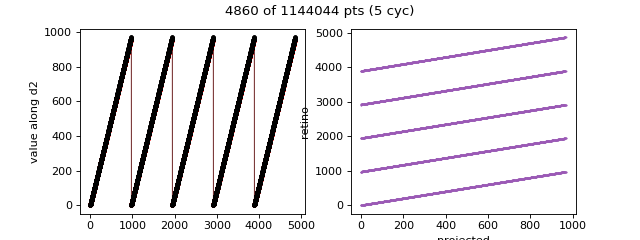

Text(0,0.5,u'retino')

In [71]:
fig, axn = pl.subplots(1,2, figsize=(8,3)) #.figure()

ncyc=5
npts = d2*ncyc
fig.suptitle("%i of %i pts (%i cyc)" % (npts, len(proj_az), ncyc))

ax = axn[0]
ax.plot(proj_az[0:npts], 'r',  marker='.', lw=0.5)
ax.plot(pix[0:npts], 'k',  marker='.', lw=.5)
#ax.plot(ret_az[0:npts], 'b', marker='.', lw=0)
ax.set_ylabel('value along d2')
ax = axn[1]
offsets = [i for i in np.arange(0, npts)]
ax.scatter(proj_az[0:npts], ret_az[0:npts]+offsets, marker='.', s=2)
ax.set_xlabel('projected')
ax.set_ylabel('retino')

<IPython.core.display.Javascript object>


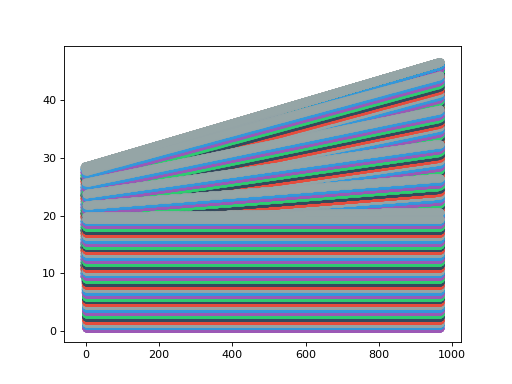

In [72]:
pl.figure()
ncyc=40
#pl.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc])
for i in np.arange(1, ncyc):
    pl.scatter(proj_az[0:d2*ncyc], ret_az[0:d2*ncyc]+i*0.5)

## Calculate gradient on retino map

In [70]:
# Convert to degrees
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [71]:
# Calculate gradients
plot_degrees = True

if plot_degrees:
    vmin=-np.pi
    vmax=np.pi
    img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                           newmin=screen_min, newmax=screen_max)
    img_el = convert_range(el_fill, oldmin=vmin, oldmax=vmax,
                           newmin=screen_min, newmax=screen_max)
    
    grad_az = calculate_gradients(img_az)
    grad_el = calculate_gradients(img_el)
    vmin, vmax = (screen_min, screen_max)

else:
    grad_az = calculate_gradients(az_fill)
    grad_el = calculate_gradients(el_fill)
    vmin, vmax = (-np.pi, np.pi)
    
print(vmin, vmax)

(-59.7782, 59.7782)


In [72]:
#plot_degrees = True

if not plot_degrees:
    img_az = convert_range(az_fill, oldmin=vmin, oldmax=vmax, 
                           newmin=screen_min, newmax=screen_max)
    img_el = convert_range(el_fille, oldmin=vmin, oldmax=vmax,
                           newmin=screen_min, newmax=screen_max)
    vmin, vmax = (screen_min, screen_max)


<IPython.core.display.Javascript object>


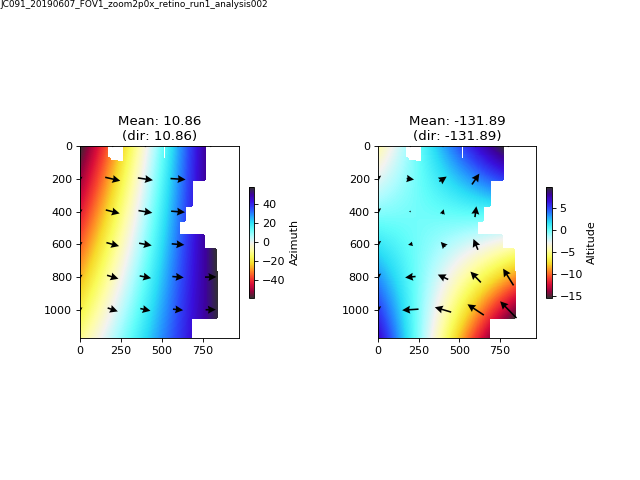

(u'/n/coxfs01/2p-data/JC091/20190607/FOV1_zoom2p0x/retino_run1/retino_analysis/analysis002_a79b6d/retino-structure', 'gradients_dilate-center-12_spatial-smooth-7_degrees_circ_magthr-0.01')


In [92]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5

plot_str = 'degrees' if plot_degrees else ''
fig, axn = pl.subplots(1, 2, figsize=(8,6))
ax = axn[0]
im = ax.imshow(img_az, cmap=cmap_phase)#, vmin=vmin, vmax=vmax)
plot_gradients(grad_az, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Azimuth')

ax = axn[1]
im = ax.imshow(img_el,cmap=cmap_phase) #, vmin=vmin, vmax=vmax)
plot_gradients(grad_el, ax=ax, draw_interval=spacing, scale=scale, width=width,
              headwidth=headwidth)
fig.colorbar(im, ax=ax, shrink=0.3, label='Altitude')

pl.subplots_adjust(wspace=0.5, hspace=0.3)

putils.label_figure(fig, data_id)
figname = 'gradients_dilate-center-%i_spatial-smooth-%i_%s_circ_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [59]:
img_el.min(), img_el.max()

(nan, nan)

In [75]:
grad_az

{'direction': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-1.57079633, -1.57079633, -1.57079633, ...,         nan,
                 nan,         nan],
        [-1.57079633, -1.5705537 , -1.57014944, ...,         nan,
                 nan,         nan],
        ..., 
        [ 1.57079633,  0.80209261,  0.37017173, ...,         nan,
                 nan,         nan],
        [ 1.57079633,  0.17148951,  0.06490979, ...,         nan,
                 nan,         nan],
        [ 0.        ,  0.        ,  0.        , ...,         nan,
                 nan,         nan]]),
 'gradient_x': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.00188032,  0.00500605, ...,         nan,
                 nan,         nan],
        ..., 
        [ 0.        ,  0.

<IPython.core.display.Javascript object>


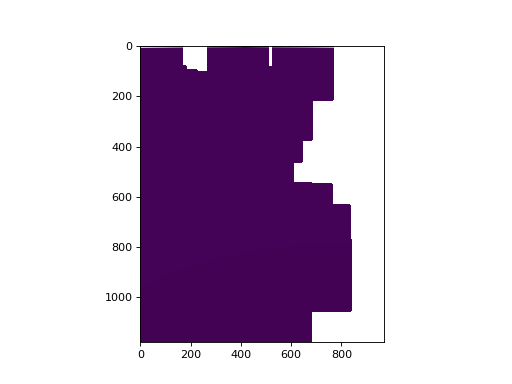

In [93]:
pl.figure()
pl.imshow(grad_az['magnitude'])

In [94]:
grad_el['mean_direction']

-2.3019512378488143

## Compute unit vector and project

In [95]:

avg_dir_el = np.rad2deg(grad_el['mean_direction'])
print('[EL]avg dir: %.2f deg' % avg_dir_el)
vhat_el = grad_el['vhat']

avg_dir_az = np.rad2deg(grad_az['mean_direction'])
print('[AZ]avg dir: %.2f deg' % avg_dir_az)
vhat_az = grad_az['vhat']

print(vhat_az, vhat_el)


[EL]avg dir: -131.89 deg
[AZ]avg dir: 10.86 deg
(array([ 0.98207551,  0.18848789]), array([-0.6677298 , -0.74440373]))


<IPython.core.display.Javascript object>


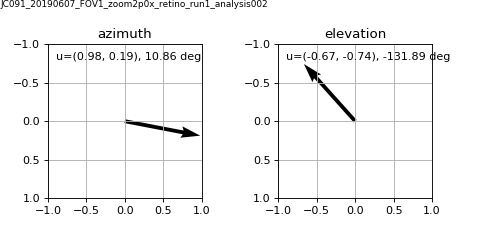

In [107]:
fig, axn = pl.subplots(1, 2, figsize=(6,3))

ax = axn[0]
ax.grid(True)
ax.set_title('azimuth')
vh = grad_az['vhat'].copy()
az_dir = np.rad2deg(np.arctan2(vh[1], vh[0])) #+ 360.) % 360
vhat_az = (np.cos(np.deg2rad(az_dir)), np.sin(np.deg2rad(az_dir)))

ax.text(-.9, -.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_az[0], vhat_az[1], az_dir))
ax.quiver(0,0, vhat_az[0], vhat_az[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

ax = axn[1]
ax.grid(True)
ax.set_title('elevation')
el_dir = np.rad2deg(np.arctan2(vhat_el[1], vhat_el[0]))
ax.text(-0.9, -0.8, "u=(%.2f, %.2f), %.2f deg" % (vhat_el[0], vhat_el[1], el_dir))
ax.quiver(0,0, vhat_el[0], vhat_el[1],  scale=1, scale_units='xy', 
          units='xy', angles='xy', width=.05, pivot='tail')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_aspect('equal')
ax.invert_yaxis()

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'gradients__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


#### Test vector directions an quiver plotting...

<IPython.core.display.Javascript object>


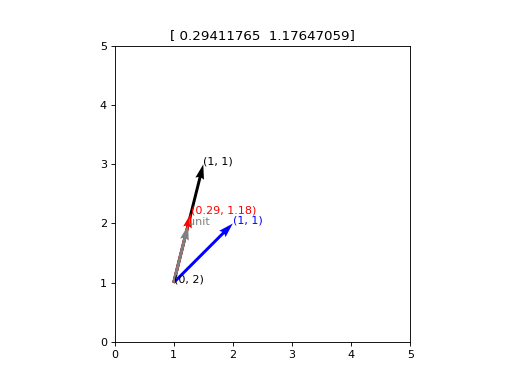

(1, 1)


Text(1.24254,1.97014,u'unit')

In [37]:
gimg=grad_az['image']
# for xi in np.arange(0, 3):
#     for yi in np.arange(0, 5):

y, x = np.mgrid[0:gimg.shape[0], 0:gimg.shape[1]]

xi=1
yi=1

fig, ax =pl.subplots()
ax.set_aspect('equal')
ax.set_ylim([0, 5])
ax.set_xlim([0, 5])
print(x[xi, yi], y[xi, yi])

v1 = np.array([0.5, 2.0])
v2 = np.array([1.0, 1.0])
vh = v1 / np.linalg.norm(v1) # unit vector

# Original vector, direction
ax.quiver(x[xi, yi], y[xi, yi], v1[0], v1[1], color='k', 
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+v1[0], y[xi, yi]+v1[1], '(%i, %i)' % (x[xi, yi], y[xi, yi]))
ax.text(x[xi, yi], y[xi, yi], '(%i, %i)' % (v1[0], v1[1]))

# V to be projected
ax.quiver(x[xi, yi], y[xi, yi], v2[0], v2[1], color='b',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+v2[0], y[xi, yi]+v2[1], '(%i, %i)' % ( v2[0], v2[1]), color='b')

# vec projection onto original
vproj = vh * np.dot(v2, vh) 
ax.quiver(x[xi, yi], y[xi, yi], vproj[0], vproj[1], color='r',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+vproj[0], y[xi, yi]+vproj[1], '(%.2f, %.2f)' % (vproj[0], vproj[1]), color='r')
ax.set_title(vproj)

# Also show unit
ax.quiver(x[xi, yi], y[xi, yi], vh[0], vh[1], color='gray',
            scale=1, scale_units='xy', units='xy', angles='xy', width=.05, pivot='tail')
ax.text(x[xi, yi]+vh[0], y[xi, yi]+vh[1], 'unit', color='gray')# % (x[xi, yi], y[xi, yi]))


## Calculate gradients and projec to get mean

In [38]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/evaluate_receptivefield_fits.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/h

<IPython.core.display.Javascript object>


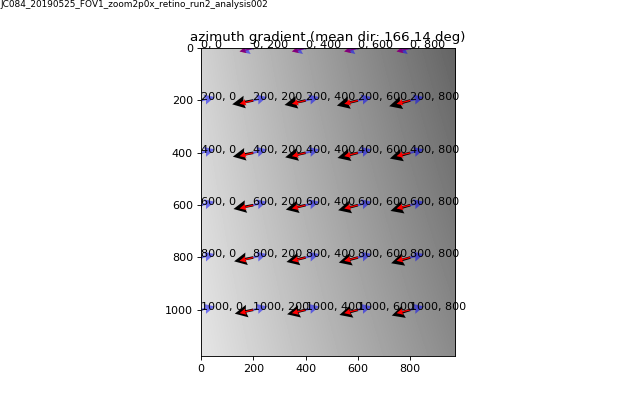

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/matplotlib/quiver.py:666: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/matplotlib/quiver.py:666: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


(u'/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_aa1019/retino-structure', 'vhat_gradients_12_spatial-smooth-7_azimuth')


In [39]:
spacing = 200
scale = None #0.0001
width = 0.01 #0.01
headwidth=5


condition = 'azimuth'

# Set limits and number of points in grid
if condition == 'azimuth':
    gimg = grad_az['image'].copy()
    vhat = grad_az['vhat']
    gdx = grad_az['gradient_x']
    gdy = grad_az['gradient_y']
    mean_dir = np.rad2deg(grad_az['mean_direction'])

elif condition == 'elevation':
    gimg = grad_el['image'].copy()
    vhat = grad_el['vhat']
    gdx = grad_el['gradient_x']
    gdy = grad_el['gradient_y']
    mean_dir = np.rad2deg(grad_el['mean_direction'])

# Every 3rd point in each direction.
y, x = np.mgrid[0:gimg.shape[0], 0:gimg.shape[1]]
skip = (slice(None, None, spacing), slice(None, None, spacing))

# Plot image
fig, ax = pl.subplots(figsize=(8,5))
ax.imshow(gimg, vmin=vmin, vmax=vmax, cmap='gray') # #, origin='top')
ax.set(aspect=1, title='%s gradient (mean dir: %.2f deg)' % (condition, mean_dir))


# Plot all the gradients
ax.quiver(x[skip], y[skip], gdx[skip], gdy[skip], 
          color='k', scale=scale, width=width, headwidth=headwidth,
          scale_units='xy', units='width', angles='xy', pivot='tail')

# Plot unit vector at each position
ax.quiver(x[skip], y[skip], vhat[0], vhat[1], #np.array((vhat_el[1])), 
              #color='r', alpha=1, width=0.005,
              color='r', scale=scale, width=0.005, headwidth=headwidth,
              scale_units='xy', units='width', angles='xy', pivot='tail')

for xi, xv in enumerate(np.arange(0, y.shape[0], spacing)):
    for yi, yv in enumerate(np.arange(0, y.shape[1], spacing)):
        #nv = (gdx[skip][xi, yi], gdy[skip][xi, yi])
        nv = np.array([y[skip][xi, yi], x[skip][xi, yi]])
        #print(xi, yi, nv)
        # vector projection onto vhat (multiply with unit vec in direction of dirvec)
        vproj = vhat * np.dot(nv, vhat) 
        ax.text(x[skip][xi, yi], y[skip][xi, yi], '%i, %i' %(xv, yv), fontsize=10)
        
        # Plot projection
        ax.quiver(x[skip][xi, yi], 
                  y[skip][xi, yi], 
                  vproj[0], vproj[1],
                  alpha=0.5, #width=0.008,
                  color='b', scale=scale, width=0.008, headwidth=headwidth,
                  scale_units='xy', units='width', angles='xy', pivot='tail')


putils.label_figure(fig, data_id)
figname = 'vhat_gradients_%i_spatial-smooth-%i_%s' % (kernel_size, smooth_fwhm, condition)

pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)


In [97]:
gimg_az = grad_az['image'].copy()
d1, d2 = grad_az['image'].shape
print(d1, d2)
vhat_az = grad_az['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
vhat_el = grad_el['vhat'].copy() #[0], -0.04) #abs(grad_az['vhat'][1]))
print(vhat_az, vhat_el)

gimg_el = grad_el['image'].copy()


(1177, 972)
(array([ 0.98207551,  0.18848789]), array([-0.6677298 , -0.74440373]))


In [98]:
proj_az = abs(np.array([np.dot(np.array((xv, yv)), vhat_az) for yv in np.arange(0, d1) for xv in np.arange(0, d2)]))
ret_az = np.array([gimg_az[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

proj_el = abs(np.array([np.dot(np.array((xv, yv)), vhat_el) for yv in np.arange(0, d1) for xv in np.arange(0, d2)]))
ret_el = np.array([gimg_el[xv, yv] for xv in np.arange(0, d1) for yv in np.arange(0, d2)] )

pix = np.array([xv for yv in np.arange(0, d1) for xv in np.arange(0, d2) ])
coords = np.array([np.array((xv, yv)) for yv in np.arange(0, d1) for xv in np.arange(0, d2)])


In [104]:
ret_az

array([  0.,   0.,   0., ...,  nan,  nan,  nan])

<IPython.core.display.Javascript object>


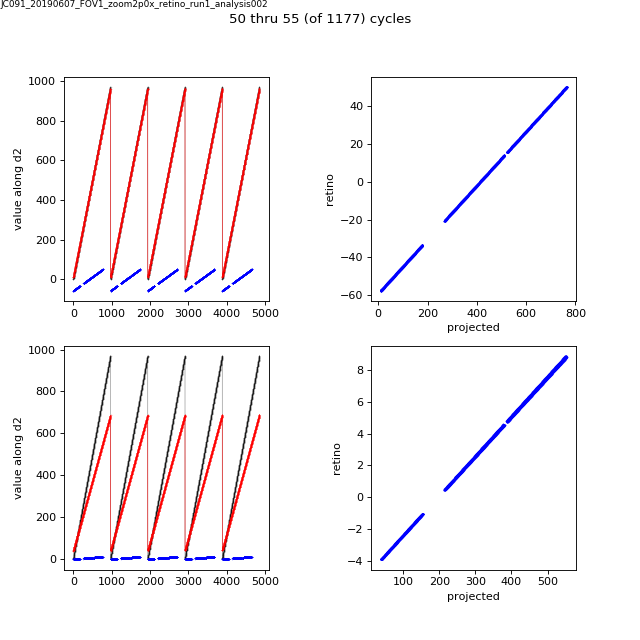

In [99]:
fig, axn = pl.subplots(2,2, figsize=(8,8)) #.figure()

ncyc=5

startcyc=50
endcyc=startcyc+ncyc

npts = d2*endcyc
spts = d2*startcyc
fig.suptitle("%i thru %i (of %i) cycles" % (startcyc, endcyc, d1))

ax = axn[0,0]
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_az[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_az[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[0,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_az[spts:npts], ret_az[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')


ax = axn[1,0]
ax.plot(pix[spts:npts], 'k',  marker='.', lw=.5, markersize=0.5, alpha=0.5)
ax.plot(proj_el[spts:npts], 'r',  marker='.', lw=0.5, markersize=0.5)
ax.plot(ret_el[spts:npts], 'b', marker='.', lw=0, markersize=0.5)

ax.set_ylabel('value along d2')
ax = axn[1,1]
offsets = [0 for i in np.arange(spts, npts)]
ax.scatter(proj_el[spts:npts], ret_el[spts:npts]+offsets, marker='.', s=2, c='b')
ax.set_xlabel('projected')
ax.set_ylabel('retino')

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'test_projections__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


## Fit linear

In [101]:
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf
import sklearn.metrics as skmetrics

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/evaluate_receptivefield_fits.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/h

<IPython.core.display.Javascript object>


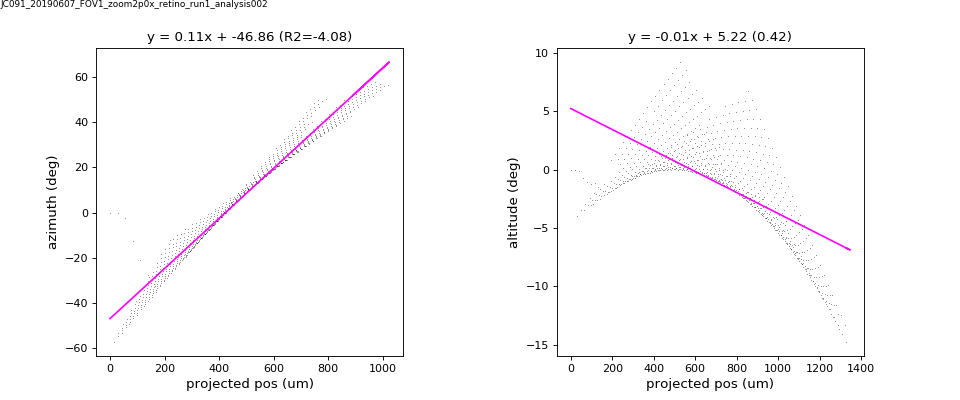

In [110]:
fitv_az, regr_az = evalrf.fit_linear_regr(proj_az[~np.isnan(ret_az)], ret_az[~np.isnan(ret_az)], return_regr=True)
fitv_el, regr_el = evalrf.fit_linear_regr(proj_el[~np.isnan(ret_el)], ret_el[~np.isnan(ret_el)], return_regr=True)

# rmse = np.sqrt(skmetrics.mean_squared_error(yv, fitv))
# r2 = skmetrics.r2_score(yv, fitv)
# pearson_p, pearson_r = spstats.pearsonr(xv, yv)

fig, axn = pl.subplots(1,2, figsize=(12, 5))
spacing=1000
ax=axn[0]
#sns.regplot(proj_az, ret_az, ax=ax, scatter=False, color='k')
ax.scatter(proj_az[0::spacing], ret_az[0::spacing], marker='.', lw=0, color='k', s=1)
ax.plot(proj_az[~np.isnan(ret_az)], fitv_az, color='magenta')
r2_az = skmetrics.r2_score(proj_az[~np.isnan(ret_az)], fitv_az)
linfit_str = 'y = %.2fx + %.2f (R2=%.2f)' % (float(regr_az.coef_), float(regr_az.intercept_), r2_az) 
ax.set_title(linfit_str)
ax.set_ylabel('azimuth (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

        
ax=axn[1]
#sns.regplot(proj_el, ret_el, ax=ax, scatter=False, color='k')
ax.scatter(proj_el[0::spacing], ret_el[0::spacing], marker='.', lw=0, color='k', s=1)
ax.plot(proj_el[~np.isnan(ret_el)], fitv_el, color='magenta')
r2_el = skmetrics.r2_score(ret_el[~np.isnan(ret_el)], fitv_el)
linfit_str = 'y = %.2fx + %.2f (%.2f)' % (float(regr_el.coef_), float(regr_el.intercept_), r2_el) 
ax.set_title(linfit_str)
ax.set_ylabel('altitude (deg)', fontsize=12)
ax.set_xlabel('projected pos (um)', fontsize=12)

label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'Proj_versus_Retinopos__dilate-center-%i_spatial-smooth-%i_%s_magthr-%.2f' % (kernel_size, smooth_fwhm, plot_str, mag_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [46]:
proj_az

array([   0.        ,   -0.97089016,   -1.94178032, ..., -659.11097785,
       -660.081868  , -661.05275816])

In [136]:
curr_dst_dir

u'/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/retino_run2/retino_analysis/analysis002_7e9e1a/retino-structure'

In [171]:
def plot_phase_map(array, zimg=None, cmap='hsv', vmin=-np.pi, vmax=np.pi, alpha=0.7,
                  plot_transparent=True, plot_smoothed=False, ax=None):
    
    norm = mcolors.Normalize(vmin, vmax)
    
    if ax is None:
        fig, ax = pl.subplots()

    if plot_transparent:
        if zimg is not None:
            ax.imshow(zimg, cmap='gray', alpha=0); ax.axis('off')
        ax.patch.set_visible(0)
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    else:
        ax.patch.set_visible(0)
        if zimg is not None:
            ax.imshow(zimg, cmap='gray'); ax.axis('off');
        im2 = ax.imshow(array, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha) #, alpha=0.7)

        pl.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    return ax

<IPython.core.display.Javascript object>


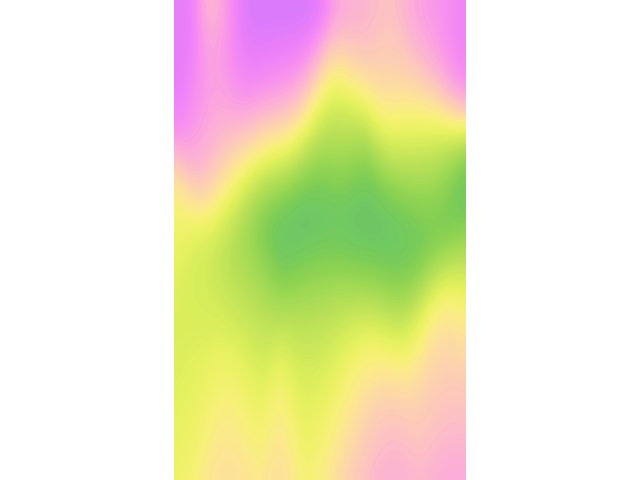

neuropil_absolute-azimuth_filter-allconds-magthr0.01_443cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [172]:

condition = 'azimuth'
if condition == 'azimuth':
    plot_arr = azim_smoothed.copy() if plot_smoothed else azim_phase_mask.copy()
elif condition == 'elevation':
    plot_arr = elev_smoothed.copy() if plot_smoothed else elev_phase_mask.copy()

fig, ax = pl.subplots()
ax = plot_phase_map(plot_arr, zimg=zimg, cmap=cmap, vmin=vmin, vmax=vmax, alpha=alpha,
                   plot_transparent=plot_transparent, plot_smoothed=plot_smoothed, ax=ax)

if label:
    for roi in tmp_rlist:
        xp, yp = np.where(masks[roi, :, :])
        ax.text(yp[0], xp[0], roi, fontsize=12, color='w')
    label_figure(fig, data_identifier)

if filter_by_mag:
    figname = '%s_absolute-%s_filter-allconds-magthr%.2f_%icells' % (trace_type, condition, mag_thr, len(roi_list))
else:
    figname = '%s_absolute-%s' % (trace_type, condition)
figname = '%s_%s_%s%s' % (figname, skey, format_str, smooth_str)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)

# Save legends

<IPython.core.display.Javascript object>


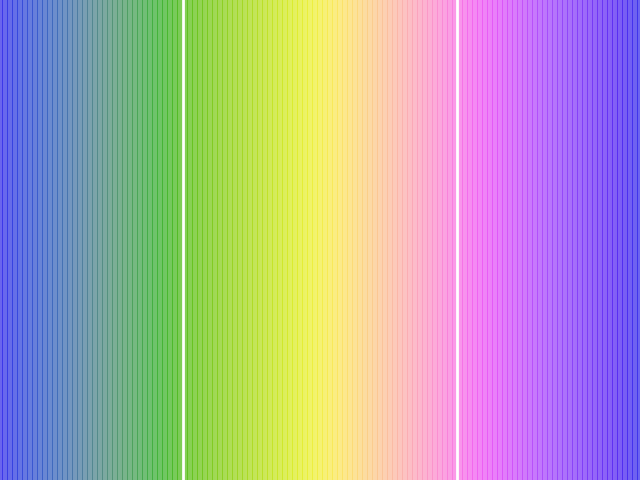

In [117]:
fig = pl.figure()

# Colorbar axes are from (0, 1) -- need to reset fraction cutoff between 0, 1...
elev_min = elev_cutoff/2.
elev_max = 1- elev_cutoff/2.

cbar1_orientation='horizontal'
cbar1_axes = [0, 0, 1, 1] #[0.31, 0.78, 0.1, 0.05]

cbaxes1 = fig.add_axes(cbar1_axes) 
cb1 = pl.colorbar(im1, cax=cbaxes1, orientation=cbar1_orientation)  
cb1.ax.axis('off')
cb1.outline.set_visible(False)
cb1.ax.axvline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb1.ax.axvline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')

pl.savefig(os.path.join(outdir, 'legend_absolute-azimuth.png')) #% (figname, label_str)))


<IPython.core.display.Javascript object>


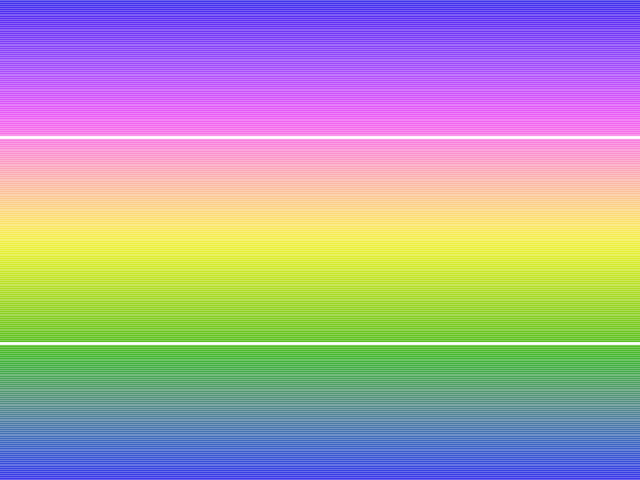

corrected_absolute-elevation_filter-allconds-magthr0.01_174cells_JC091-20190623-FOV1_zoom1p0x-retino_run1-analysis002__transparent_smooth-25


In [118]:
fig = pl.figure()

cbar2_orientation='vertical'
cbar2_axes = [0, 0, 1, 1] #[0.79, 0.78, 0.1, 0.05]

cbaxes2 = fig.add_axes(cbar2_axes) 
cb2 = pl.colorbar(im2, cax=cbaxes2, orientation=cbar2_orientation)
#cb2.ax.set_ylim(-vmax*elev_cutoff, vmax*elev_cutoff)
cb2.ax.axhline(elev_max, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axhline(elev_min, lw=2, color='w') #*np.pi,lw=2, color='w')
cb2.ax.axis('off')
cb2.outline.set_visible(False)


#label_figure(fig, data_identifier)
pl.savefig(os.path.join(outdir, 'legend_absolute-elevation.png')) #% (figname, label_str)))

print(figname)